# Compare analyzers on MNIST - for all output neurons

This notebook shows how saliency maps are computed for various methods on the MNIST dataset. It is based on the [method comparison on MNIST](mnist_method_comparison.ipynb) notebook, but extends it by looking at the analysis of all output neurons!

We will first train a simple 3-layer MLP and then apply different methods. In the end we allow for a qualitive assesment by plotting the analysis as a grid.

Parts of the code that do not contribute to the main focus are outsourced into utility modules. To learn more about the basic usage of **iNNvestigate** have look into this notebook: [Introduction to iNNvestigate](introduction.ipynb) and [Comparing methods on MNIST](mnist_method_comparison.ipynb)

## Imports

In [1]:
#%load_ext autoreload
#%autoreload 2

import warnings
warnings.simplefilter('ignore')

In [2]:
%matplotlib inline  

import imp
import numpy as np
import os

import tensorflow.keras as keras
import tensorflow.keras.backend as keras_backend
import tensorflow.keras.models as keras_models

import innvestigate
import innvestigate.utils as iutils

# Use utility libraries to focus on relevant iNNvestigate routines.
eutils = imp.load_source("utils", "../utils.py")
mnistutils = imp.load_source("utils_mnist", "../utils_mnist.py")

## Data
Load the dataset and keep some images from the test set for the analysis.

In [3]:
# Load data
# returns x_train, y_train, x_test, y_test as numpy.ndarray
data_not_preprocessed = mnistutils.fetch_data()

# Create preprocessing functions
input_range = [-1, 1]
preprocess, revert_preprocessing = mnistutils.create_preprocessing_f(data_not_preprocessed[0], input_range)

# Preprocess data
data = (
    preprocess(data_not_preprocessed[0]), data_not_preprocessed[1],
    preprocess(data_not_preprocessed[2]), data_not_preprocessed[3]
)

num_classes = len(np.unique(data[1]))
label_to_class_name = [str(i) for i in range(num_classes)]

## Model
The next part trains and evaluates a CNN.

In [4]:
# Create & train model
if keras.backend.image_data_format == "channels_first":
    input_shape = (1, 28, 28)
else:
    input_shape = (28, 28, 1)

model = keras.models.Sequential([
    keras.layers.Conv2D(32, (3, 3), activation="relu", input_shape=input_shape),
    keras.layers.Conv2D(64, (3, 3), activation="relu"),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation="relu"),
    keras.layers.Dense(10, activation="softmax"),
])

scores = mnistutils.train_model(model, data, batch_size=128, epochs=20)
print("Scores on test set: loss=%s accuracy=%s" % tuple(scores))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Train on 60000 samples
Epoch 1/20
60000/60000 [==============================] - 3s 57us/sample - loss: 0.1403 - acc: 0.9573
Epoch 2/20
60000/60000 [==============================] - 2s 39us/sample - loss: 0.0371 - acc: 0.9881
Epoch 3/20
60000/60000 [==============================] - 2s 38us/sample - loss: 0.0223 - acc: 0.9928
Epoch 4/20
60000/60000 [==============================] - 2s 39us/sample - loss: 0.0133 - acc: 0.9959
Epoch 5/20
60000/60000 [==============================] - 2s 38us/sample - loss: 0.0100 - acc: 0.9966
Epoch 6/20
60000/60000 [==============================] - 2s 39us/sample - loss: 0.0088 - acc: 0.9969
Epoch 7/20
60000/60000 [==============================] - 2s 39us/sample - loss: 0.0065 - acc: 0.9977
Epoch 8/20
60000/60000 [==============================] - 2s 39us/sample - loss: 0.0067 - acc: 0.9977
Epoch 9/20
60000/60000 [==============================] - 2s 38us/sample - loss:

## Analysis

Next, we will set up a list of analysis methods by preparing tuples containing the methods' string identifiers used by `innvestigate.analyzer.create_analyzer(...)`, some optional parameters, a post processing choice for visualizing the computed analysis and a title for the figure to render. Analyzers can be deactivated by simply commenting the corresponding lines, or added by creating a new tuple as below.

For a full list of methods refer to the dictionary `investigate.analyzer.analyzers`

In [5]:
# Scale to [0, 1] range for plotting.
def input_postprocessing(X):
    return revert_preprocessing(X) / 255

noise_scale = (input_range[1]-input_range[0]) * 0.1
ri = input_range[0]  # reference input


# Configure analysis methods and properties
methods = [
    # NAME                    OPT.PARAMS                POSTPROC FXN               TITLE

    # Show input
    ("input",                 {},                       input_postprocessing,      "Input"),

    # Function
    ("gradient",              {"postprocess": "abs"},   mnistutils.graymap,        "Gradient"),
    #("smoothgrad",            {"noise_scale": noise_scale,
    #                           "postprocess": "square"},mnistutils.graymap,        "SmoothGrad"),

    # Signal
    ("deconvnet",             {},                       mnistutils.bk_proj,        "Deconvnet"),
    ("guided_backprop",       {},                       mnistutils.bk_proj,        "Guided Backprop",),
    #("pattern.net",           {"pattern_type": "relu"}, mnistutils.bk_proj,        "PatternNet"),

    # Interaction
    #("pattern.attribution",   {"pattern_type": "relu"}, mnistutils.heatmap,        "PatternAttribution"),
    ("deep_taylor.bounded",   {"low": input_range[0],
                               "high": input_range[1]}, mnistutils.heatmap,        "DeepTaylor"),
    #("input_t_gradient",      {},                       mnistutils.heatmap,        "Input * Gradient"),
    #("integrated_gradients",  {"reference_inputs": ri}, mnistutils.heatmap,        "Integrated Gradients"),
    #("deep_lift.wrapper",     {"reference_inputs": ri}, mnistutils.heatmap,        "DeepLIFT Wrapper - Rescale"),
    #("deep_lift.wrapper",     {"reference_inputs": ri, "nonlinear_mode": "reveal_cancel"},
    #                                                    mnistutils.heatmap,        "DeepLIFT Wrapper - RevealCancel"),
    ("lrp.z",                 {},                       mnistutils.heatmap,        "LRP-Z"),
    ("lrp.epsilon",           {"epsilon": 1},           mnistutils.heatmap,        "LRP-Epsilon"),
]

The main loop below will now instantiate the analyzer objects based on the loaded/trained model and the analyzers' parameterizations above.

In [6]:
# Create model without trailing softmax
model_wo_softmax = iutils.keras.graph.model_wo_softmax(model)

# Create analyzers.
analyzers = []
for method in methods:
    analyzer = innvestigate.create_analyzer(
        method[0],                     # analysis method identifier
        model_wo_softmax,              # model without softmax output
        neuron_selection_mode="index", # We want to select the output neuron to analyze.
        **method[1])                   # optional analysis parameters

    # Some analyzers require training.
    analyzer.fit(data[0], batch_size=256, verbose=1)
    analyzers.append(analyzer)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Now we analyze each image with the different analyzers on all output neurons:

INFO:tensorflow:Converted call: <bound method GatherND.call of <innvestigate.layers.GatherND object at 0x7f5cd4460c90>>
    args: ([<tf.Tensor 'dense_2/BiasAdd:0' shape=(?, 10) dtype=float32>, <tf.Tensor 'iNNvestigate_neuron_indexing:0' shape=(?, ?) dtype=int32>],)
    kwargs: {}

Converted call: <bound method GatherND.call of <innvestigate.layers.GatherND object at 0x7f5cd4460c90>>
    args: ([<tf.Tensor 'dense_2/BiasAdd:0' shape=(?, 10) dtype=float32>, <tf.Tensor 'iNNvestigate_neuron_indexing:0' shape=(?, ?) dtype=int32>],)
    kwargs: {}

INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7f5cd45b45a0>: default rule
Not whitelisted: <method-wrapper '__call__' of method object at 0x7f5cd45b45a0>: default rule
INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers.GatherND'>: default rule
Not whitelisted: <class 'innvestigate.layers.GatherND'>: default rule
INFO:tensorflow:Not whitelisted: <bound method GatherND.call of <innvestigate.layers.GatherN

Entity <bound method _Map.call of <innvestigate.layers.Identity object at 0x7f5cac1f8390>> is not cached for key <code object call at 0x7f5cd6c8f420, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/layers.py", line 272> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7f5cd3cd2050>, frozenset())
INFO:tensorflow:Converting <bound method _Map.call of <innvestigate.layers.Identity object at 0x7f5cac1f8390>>
Converting <bound method _Map.call of <innvestigate.layers.Identity object at 0x7f5cac1f8390>>
INFO:tensorflow:Source code of <bound method _Map.call of <innvestigate.layers.Identity object at 0x7f5cac1f8390>>:

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals
def call(self, x):
    if isinstance(x, list) and len(x) == 1:
        x = x[0]
    return self._apply_map(x)


Source code of <bound method _Map.call of <innvestigate.layers.Identity 

Compiled AST of <bound method _Map.call of <innvestigate.layers.Identity object at 0x7f5cac1f8390>>:

FunctionDef:
| name=u"tf__call"
| args=arguments:
| | args=[
| | | Name:
| | | | id=u"self"
| | | | ctx=Param()
| | | | annotation=None
| | | | ___pyct_anno={'lineno': 5, ORIGIN: layers.py:272:13, QN: self, DEFINITIONS: (AnnotatedDef[140036001145552],), ORIG_DEFINITIONS: (AnnotatedDef[140036001199760],)}
| | | Name:
| | | | id=u"x"
| | | | ctx=Param()
| | | | annotation=None
| | | | ___pyct_anno={'lineno': 5, ORIGIN: layers.py:272:19, QN: x, DEFINITIONS: (AnnotatedDef[140036000913488],), ORIG_DEFINITIONS: (AnnotatedDef[140036001199312],)}
| | ]
| | vararg=None
| | kwonlyargs=[]
| | kw_defaults=[]
| | kwarg=None
| | defaults=[]
| | ___pyct_anno={SCOPE: Scope{r=(), w=(self, x)}}
| body=[
| | Assign:
| | | targets=[
| | | | Name:
| | | | | id=u"do_return"
| | | | | ctx=Store()
| | | | | annotation=None
| | | | | ___pyct_anno={QN: do_return, DEFINITIONS: (AnnotatedDef[140036000913808],)}
|

Defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__call at 0x7f5cac1d3050> : None
INFO:tensorflow:KW defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__call at 0x7f5cac1d3050> : None
KW defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__call at 0x7f5cac1d3050> : None
INFO:tensorflow:Calling <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__call at 0x7f5cac1d3050> with
    self: <innvestigate.layers.Identity object at 0x7f5cac1f8390>
    x: Tensor("conv2d_input:0", shape=(?, 28, 28, 1), dtype=float32)

Calling <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__call at 0x7f5cac1d3050> with
    self: <innvestigate.layers.Identity object at 0x7f5cac1f8390>
    x: Tensor("conv2d_input:0", shape=(?, 28, 28, 1), dtype=float32)

INFO:tensorflow:Converted call: <built-in funct

Compiled AST of <bound method Identity._apply_map of <innvestigate.layers.Identity object at 0x7f5cac1f8390>>:

FunctionDef:
| name=u"tf___apply_map"
| args=arguments:
| | args=[
| | | Name:
| | | | id=u"self"
| | | | ctx=Param()
| | | | annotation=None
| | | | ___pyct_anno={'lineno': 5, ORIGIN: layers.py:285:19, QN: self, DEFINITIONS: (AnnotatedDef[140036667060176],), ORIG_DEFINITIONS: (AnnotatedDef[140036001289424],)}
| | | Name:
| | | | id=u"x"
| | | | ctx=Param()
| | | | annotation=None
| | | | ___pyct_anno={'lineno': 5, ORIGIN: layers.py:285:25, QN: x, DEFINITIONS: (AnnotatedDef[140036001144976],), ORIG_DEFINITIONS: (AnnotatedDef[140036000980112],)}
| | ]
| | vararg=None
| | kwonlyargs=[]
| | kw_defaults=[]
| | kwarg=None
| | defaults=[]
| | ___pyct_anno={SCOPE: Scope{r=(), w=(self, x)}}
| body=[
| | Assign:
| | | targets=[
| | | | Name:
| | | | | id=u"do_return"
| | | | | ctx=Store()
| | | | | annotation=None
| | | | | ___pyct_anno={QN: do_return, DEFINITIONS: (AnnotatedDef[14003

Converted call: <bound method GatherND.call of <innvestigate.layers.GatherND object at 0x7f5cac1d7bd0>>
    args: ([<tf.Tensor 'dense_2/BiasAdd:0' shape=(?, 10) dtype=float32>, <tf.Tensor 'iNNvestigate_neuron_indexing_1:0' shape=(?, ?) dtype=int32>],)
    kwargs: {}

INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7f5cd4577640>: default rule
Not whitelisted: <method-wrapper '__call__' of method object at 0x7f5cd4577640>: default rule
INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers.GatherND'>: default rule
Not whitelisted: <class 'innvestigate.layers.GatherND'>: default rule
INFO:tensorflow:Not whitelisted: <bound method GatherND.call of <innvestigate.layers.GatherND object at 0x7f5cac1d7bd0>>: default rule
Not whitelisted: <bound method GatherND.call of <innvestigate.layers.GatherND object at 0x7f5cac1d7bd0>>: default rule
INFO:tensorflow:Entity <bound method GatherND.call of <innvestigate.layers.GatherND object at 0x7f5cac1d7bd0>> is not 

Compiled AST of <bound method GatherND.call of <innvestigate.layers.GatherND object at 0x7f5cac1d7bd0>>:

FunctionDef:
| name=u"tf__call"
| args=arguments:
| | args=[
| | | Name:
| | | | id=u"self"
| | | | ctx=Param()
| | | | annotation=None
| | | | ___pyct_anno={'lineno': 5, ORIGIN: layers.py:660:13, QN: self, DEFINITIONS: (AnnotatedDef[140036667059024],), ORIG_DEFINITIONS: (AnnotatedDef[140036001011152],)}
| | | Name:
| | | | id=u"inputs"
| | | | ctx=Param()
| | | | annotation=None
| | | | ___pyct_anno={'lineno': 5, ORIGIN: layers.py:660:19, QN: inputs, DEFINITIONS: (AnnotatedDef[140036001330768],), ORIG_DEFINITIONS: (AnnotatedDef[140036001010704],)}
| | ]
| | vararg=None
| | kwonlyargs=[]
| | kw_defaults=[]
| | kwarg=None
| | defaults=[]
| | ___pyct_anno={SCOPE: Scope{r=(), w=(self, inputs)}}
| body=[
| | Assign:
| | | targets=[
| | | | Name:
| | | | | id=u"do_return"
| | | | | ctx=Store()
| | | | | annotation=None
| | | | | ___pyct_anno={QN: do_return, DEFINITIONS: (AnnotatedDef[14

Defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__call at 0x7f5cac1d3a70> : None
INFO:tensorflow:KW defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__call at 0x7f5cac1d3a70> : None
KW defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__call at 0x7f5cac1d3a70> : None
INFO:tensorflow:Calling <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__call at 0x7f5cac1d3a70> with
    self: <innvestigate.layers.GatherND object at 0x7f5cac1d7bd0>
    inputs: [<tf.Tensor 'dense_2/BiasAdd:0' shape=(?, 10) dtype=float32>, <tf.Tensor 'iNNvestigate_neuron_indexing_1:0' shape=(?, ?) dtype=int32>]

Calling <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__call at 0x7f5cac1d3a70> with
    self: <innvestigate.layers.GatherND object at 0x7f5cac1d7bd0>
    inputs: [<tf.Tensor 'dense_2/BiasAd

Compiled AST of <bound method OnesLike.call of <innvestigate.layers.OnesLike object at 0x7f5cac171e90>>:

FunctionDef:
| name=u"tf__call"
| args=arguments:
| | args=[
| | | Name:
| | | | id=u"self"
| | | | ctx=Param()
| | | | annotation=None
| | | | ___pyct_anno={'lineno': 5, ORIGIN: layers.py:99:13, QN: self, DEFINITIONS: (AnnotatedDef[140036000999952],), ORIG_DEFINITIONS: (AnnotatedDef[140036000847824],)}
| | | Name:
| | | | id=u"x"
| | | | ctx=Param()
| | | | annotation=None
| | | | ___pyct_anno={'lineno': 5, ORIGIN: layers.py:99:19, QN: x, DEFINITIONS: (AnnotatedDef[140036001271248],), ORIG_DEFINITIONS: (AnnotatedDef[140036000979024],)}
| | ]
| | vararg=None
| | kwonlyargs=[]
| | kw_defaults=[]
| | kwarg=None
| | defaults=[]
| | ___pyct_anno={SCOPE: Scope{r=(), w=(self, x)}}
| body=[
| | Assign:
| | | targets=[
| | | | Name:
| | | | | id=u"do_return"
| | | | | ctx=Store()
| | | | | annotation=None
| | | | | ___pyct_anno={QN: do_return, DEFINITIONS: (AnnotatedDef[140036001201552],)}

Defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__call at 0x7f5cac1d3200> : None
INFO:tensorflow:KW defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__call at 0x7f5cac1d3200> : None
KW defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__call at 0x7f5cac1d3200> : None
INFO:tensorflow:Calling <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__call at 0x7f5cac1d3200> with
    self: <innvestigate.layers.OnesLike object at 0x7f5cac171e90>
    x: Tensor("iNNvestigate_gather_nd_1/add:0", dtype=float32)

Calling <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__call at 0x7f5cac1d3200> with
    self: <innvestigate.layers.OnesLike object at 0x7f5cac171e90>
    x: Tensor("iNNvestigate_gather_nd_1/add:0", dtype=float32)

INFO:tensorflow:Converted call: <function to_list at 0x7f5c

Traceback (most recent call last):
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/api.py", line 506, in converted_call
    converted_f = conversion.convert(target_entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 322, in convert
    free_nonglobal_var_names)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 240, in _convert_with_cache
    entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 471, in convert_entity_to_ast

INFO:tensorflow:Compiled output of <function to_list at 0x7f5cd6ca1170>:

# coding=utf-8
def tf__to_list(l):
  """ If not list, wraps parameter into a list."""
  do_return = False
  retval_ = ag__.UndefinedReturnValue()
  with ag__.FunctionScope('to_list', 'to_list_scope', ag__.STD) as to_list_scope:

    def get_state():
      return ()

    def set_state(_):
      pass

    def if_true():
      do_return = True
      retval_ = to_list_scope.mark_return_value([l])
      return retval_, do_return

    def if_false():
      do_return = True
      retval_ = to_list_scope.mark_return_value(l)
      return retval_, do_return
    cond = ag__.not_(ag__.converted_call(isinstance, to_list_scope.callopts, (l, list), None, to_list_scope))
    retval_, do_return = ag__.if_stmt(cond, if_true, if_false, get_state, set_state, ('retval_', 'do_return'), ())
  do_return,
  return ag__.retval(retval_)


Compiled output of <function to_list at 0x7f5cd6ca1170>:

# coding=utf-8
def tf__to_list(l):
  """ If

Compiled AST of <function to_list at 0x7f5cd6ca1170>:

FunctionDef:
| name=u"tf__to_list"
| args=arguments:
| | args=[
| | | Name:
| | | | id=u"l"
| | | | ctx=Param()
| | | | annotation=None
| | | | ___pyct_anno={'lineno': 5, ORIGIN: __init__.py:45:12, QN: l, DEFINITIONS: (AnnotatedDef[140036000879120],), ORIG_DEFINITIONS: (AnnotatedDef[140036000887888],)}
| | ]
| | vararg=None
| | kwonlyargs=[]
| | kw_defaults=[]
| | kwarg=None
| | defaults=[]
| | ___pyct_anno={SCOPE: Scope{r=(), w=(l,)}}
| body=[
| | Expr:
| | | value=Str:
| | | | s=u" If not list, wraps parameter into a list."
| | | | ___pyct_anno={'lineno': 6, ORIGIN: __init__.py:46:4}
| | | ___pyct_anno={'lineno': 6, ORIGIN: __init__.py:46:4, SCOPE: Scope{r=(), w=()}, LIVE_VARS_OUT: frozenset({ag__.if_stmt, to_list_scope.mark_return_value, to_list_scope.callopts, ag__, isinstance, l, ag__.converted_call, ag__.retval, ag__.FunctionScope, ag__.UndefinedReturnValue, ag__.STD, list}), LIVE_VARS_IN: frozenset({ag__.if_stmt, to_list_sco

Defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__to_list at 0x7f5cac1d6710> : None
INFO:tensorflow:KW defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__to_list at 0x7f5cac1d6710> : None
KW defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__to_list at 0x7f5cac1d6710> : None
INFO:tensorflow:Calling <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__to_list at 0x7f5cac1d6710> with
    l: Tensor("iNNvestigate_gather_nd_1/add:0", dtype=float32)

Calling <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__to_list at 0x7f5cac1d6710> with
    l: Tensor("iNNvestigate_gather_nd_1/add:0", dtype=float32)

INFO:tensorflow:Converted call: <built-in function isinstance>
    args: (<tf.Tensor 'iNNvestigate_gather_nd_1/add:0' shape=<unknown> dtype=float32>, <class 'list'>)
    kwargs

Error transforming entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f5cac1ac650>>
INFO:tensorflow:Converted call: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f5cac171090>>
    args: ([<tf.Tensor 'dense/Relu:0' shape=(?, 512) dtype=float32>, <tf.Tensor 'dense_2/BiasAdd:0' shape=(?, 10) dtype=float32>, <tf.Tensor 'gradient_wrt/gradients/iNNvestigate_gather_nd_1/GatherNd_grad/ScatterNd:0' shape=(?, 10) dtype=float32>],)
    kwargs: {}

Converted call: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f5cac171090>>
    args: ([<tf.Tensor 'dense/Relu:0' shape=(?, 512) dtype=float32>, <tf.Tensor 'dense_2/BiasAdd:0' shape=(?, 10) dtype=float32>, <tf.Tensor 'gradient_wrt/gradients/iNNvestigate_gather_nd_1/GatherNd_grad/ScatterNd:0' shape=(?, 10) dtype=float32>],)
    kwargs: {}

INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7f5cd4494e10>: default rule
Not 

Converted call: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f5cac1a3cd0>>
    args: ([<tf.Tensor 'flatten/Reshape:0' shape=(?, 9216) dtype=float32>, <tf.Tensor 'dense/Relu:0' shape=(?, 512) dtype=float32>, <tf.Tensor 'gradient_wrt_1/gradients/dense_2/MatMul_grad/MatMul:0' shape=(?, 512) dtype=float32>],)
    kwargs: {}

INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7f5d543270a0>: default rule
Not whitelisted: <method-wrapper '__call__' of method object at 0x7f5d543270a0>: default rule
INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers.GradientWRT'>: default rule
Not whitelisted: <class 'innvestigate.layers.GradientWRT'>: default rule
INFO:tensorflow:Not whitelisted: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f5cac1a3cd0>>: default rule
Not whitelisted: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f5cac1a3cd0>>: default rule
INFO:tenso

Not whitelisted: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f5cac186c90>>: default rule
INFO:tensorflow:Entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f5cac186c90>> is not cached for key <code object call at 0x7f5cd6c8b660, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/layers.py", line 139> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7f5cac16b390>, frozenset())
Entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f5cac186c90>> is not cached for key <code object call at 0x7f5cd6c8b660, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/layers.py", line 139> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7f5cac16b390>, frozenset())
INFO:tensorflow:Converting <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f5cac186c90>>
Converting <bound method Gradi

Converting <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f5cac186210>>
INFO:tensorflow:Source code of <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f5cac186210>>:

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals
def call(self, x):
    assert isinstance(x, (list, tuple))
    Xs, tmp_Ys = x[:self.n_inputs], x[self.n_inputs:]
    assert len(tmp_Ys) % 2 == 0
    len_Ys = len(tmp_Ys) // 2
    Ys, known_Ys = tmp_Ys[:len_Ys], tmp_Ys[len_Ys:]

    ret = tensorflow.gradients(Ys, Xs,
                               grad_ys=known_Ys,
                               stop_gradients=Xs)

    if self.mask is not None:
        ret = [x for c, x in zip(self.mask, ret) if c]
    self.__workaround__len_ret = len(ret)
    return ret


Source code of <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f5cac186210>>

Source code of <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f5cac171890>>:

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals
def call(self, x):
    assert isinstance(x, (list, tuple))
    Xs, tmp_Ys = x[:self.n_inputs], x[self.n_inputs:]
    assert len(tmp_Ys) % 2 == 0
    len_Ys = len(tmp_Ys) // 2
    Ys, known_Ys = tmp_Ys[:len_Ys], tmp_Ys[len_Ys:]

    ret = tensorflow.gradients(Ys, Xs,
                               grad_ys=known_Ys,
                               stop_gradients=Xs)

    if self.mask is not None:
        ret = [x for c, x in zip(self.mask, ret) if c]
    self.__workaround__len_ret = len(ret)
    return ret


INFO:tensorflow:Error transforming entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f5cac171890>>
Traceback (most recent call last):
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/l

Error transforming entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f5cac1a3f10>>
INFO:tensorflow:Converted call: <bound method GatherND.call of <innvestigate.layers.GatherND object at 0x7f5cac1b7110>>
    args: ([<tf.Tensor 'dense_2/BiasAdd:0' shape=(?, 10) dtype=float32>, <tf.Tensor 'iNNvestigate_neuron_indexing_2:0' shape=(?, ?) dtype=int32>],)
    kwargs: {}

Converted call: <bound method GatherND.call of <innvestigate.layers.GatherND object at 0x7f5cac1b7110>>
    args: ([<tf.Tensor 'dense_2/BiasAdd:0' shape=(?, 10) dtype=float32>, <tf.Tensor 'iNNvestigate_neuron_indexing_2:0' shape=(?, ?) dtype=int32>],)
    kwargs: {}

INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7f5cdc1f99b0>: default rule
Not whitelisted: <method-wrapper '__call__' of method object at 0x7f5cdc1f99b0>: default rule
INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers.GatherND'>: default rule
Not whitelisted: <class 'innvestigate.

Error transforming entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f5cac1acc10>>
INFO:tensorflow:Converted call: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f5cac18b9d0>>
    args: ([<tf.Tensor 'dense/Relu:0' shape=(?, 512) dtype=float32>, <tf.Tensor 'dense_2/BiasAdd:0' shape=(?, 10) dtype=float32>, <tf.Tensor 'gradient_wrt_7/gradients/iNNvestigate_gather_nd_2/GatherNd_grad/ScatterNd:0' shape=(?, 10) dtype=float32>],)
    kwargs: {}

Converted call: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f5cac18b9d0>>
    args: ([<tf.Tensor 'dense/Relu:0' shape=(?, 512) dtype=float32>, <tf.Tensor 'dense_2/BiasAdd:0' shape=(?, 10) dtype=float32>, <tf.Tensor 'gradient_wrt_7/gradients/iNNvestigate_gather_nd_2/GatherNd_grad/ScatterNd:0' shape=(?, 10) dtype=float32>],)
    kwargs: {}

INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7f5cac18f370>: default rule


Converted call: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f5cac0dc350>>
    args: ([<tf.Tensor 'max_pooling2d/MaxPool:0' shape=(?, 12, 12, 64) dtype=float32>, <tf.Tensor 'flatten/Reshape:0' shape=(?, 9216) dtype=float32>, <tf.Tensor 'gradients/reversed_dense/MatMul_grad/MatMul:0' shape=(?, 9216) dtype=float32>],)
    kwargs: {}

INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7f5cac18f370>: default rule
Not whitelisted: <method-wrapper '__call__' of method object at 0x7f5cac18f370>: default rule
INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers.GradientWRT'>: default rule
Not whitelisted: <class 'innvestigate.layers.GradientWRT'>: default rule
INFO:tensorflow:Not whitelisted: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f5cac0dc350>>: default rule
Not whitelisted: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f5cac0dc350>>: default rule

Not whitelisted: <class 'innvestigate.layers.GradientWRT'>: default rule
INFO:tensorflow:Not whitelisted: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f5cac0dc050>>: default rule
Not whitelisted: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f5cac0dc050>>: default rule
INFO:tensorflow:Entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f5cac0dc050>> is not cached for key <code object call at 0x7f5cd6c8b660, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/layers.py", line 139> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7f5cac10b490>, frozenset())
Entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f5cac0dc050>> is not cached for key <code object call at 0x7f5cd6c8b660, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/layers.py", line 139> subkey (<tensorflow.python.autograph.core.conve

Traceback (most recent call last):
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/api.py", line 506, in converted_call
    converted_f = conversion.convert(target_entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 322, in convert
    free_nonglobal_var_names)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 240, in _convert_with_cache
    entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 471, in convert_entity_to_ast

INFO:tensorflow:Converted call: <bound method GatherND.call of <innvestigate.layers.GatherND object at 0x7f5cac1b7f90>>
    args: ([<tf.Tensor 'dense_2/BiasAdd:0' shape=(?, 10) dtype=float32>, <tf.Tensor 'iNNvestigate_neuron_indexing_3:0' shape=(?, ?) dtype=int32>],)
    kwargs: {}

Converted call: <bound method GatherND.call of <innvestigate.layers.GatherND object at 0x7f5cac1b7f90>>
    args: ([<tf.Tensor 'dense_2/BiasAdd:0' shape=(?, 10) dtype=float32>, <tf.Tensor 'iNNvestigate_neuron_indexing_3:0' shape=(?, ?) dtype=int32>],)
    kwargs: {}

INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7f5cac1972d0>: default rule
Not whitelisted: <method-wrapper '__call__' of method object at 0x7f5cac1972d0>: default rule
INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers.GatherND'>: default rule
Not whitelisted: <class 'innvestigate.layers.GatherND'>: default rule
INFO:tensorflow:Not whitelisted: <bound method GatherND.call of <innvestigate.layers.Gat

Error transforming entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f5cac0a5150>>
INFO:tensorflow:Converted call: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f5cac113d50>>
    args: ([<tf.Tensor 'dense/Relu:0' shape=(?, 512) dtype=float32>, <tf.Tensor 'dense_2/BiasAdd:0' shape=(?, 10) dtype=float32>, <tf.Tensor 'gradient_wrt_11/gradients/iNNvestigate_gather_nd_3/GatherNd_grad/ScatterNd:0' shape=(?, 10) dtype=float32>],)
    kwargs: {}

Converted call: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f5cac113d50>>
    args: ([<tf.Tensor 'dense/Relu:0' shape=(?, 512) dtype=float32>, <tf.Tensor 'dense_2/BiasAdd:0' shape=(?, 10) dtype=float32>, <tf.Tensor 'gradient_wrt_11/gradients/iNNvestigate_gather_nd_3/GatherNd_grad/ScatterNd:0' shape=(?, 10) dtype=float32>],)
    kwargs: {}

INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7f5cac13dd20>: default rul

Converted call: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f5cac15b4d0>>
    args: ([<tf.Tensor 'max_pooling2d/MaxPool:0' shape=(?, 12, 12, 64) dtype=float32>, <tf.Tensor 'flatten/Reshape:0' shape=(?, 9216) dtype=float32>, <tf.Tensor 'gradients_3/dense/MatMul_grad/MatMul:0' shape=(?, 9216) dtype=float32>],)
    kwargs: {}

INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7f5cac1c0a50>: default rule
Not whitelisted: <method-wrapper '__call__' of method object at 0x7f5cac1c0a50>: default rule
INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers.GradientWRT'>: default rule
Not whitelisted: <class 'innvestigate.layers.GradientWRT'>: default rule
INFO:tensorflow:Not whitelisted: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f5cac15b4d0>>: default rule
Not whitelisted: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f5cac15b4d0>>: default rule
INFO:t

Not whitelisted: <class 'innvestigate.layers.GradientWRT'>: default rule
INFO:tensorflow:Not whitelisted: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f5cac0ce510>>: default rule
Not whitelisted: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f5cac0ce510>>: default rule
INFO:tensorflow:Entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f5cac0ce510>> is not cached for key <code object call at 0x7f5cd6c8b660, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/layers.py", line 139> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7f5cac0cedd0>, frozenset())
Entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f5cac0ce510>> is not cached for key <code object call at 0x7f5cd6c8b660, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/layers.py", line 139> subkey (<tensorflow.python.autograph.core.conve

Defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__call at 0x7f5cac126b90> : None
INFO:tensorflow:KW defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__call at 0x7f5cac126b90> : None
KW defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__call at 0x7f5cac126b90> : None
INFO:tensorflow:Calling <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__call at 0x7f5cac126b90> with
    self: <innvestigate.layers.GatherND object at 0x7f5cac0bdcd0>
    inputs: [<tf.Tensor 're_lu/Relu:0' shape=(?, 10) dtype=float32>, <tf.Tensor 'iNNvestigate_neuron_indexing_4:0' shape=(?, ?) dtype=int32>]

Calling <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__call at 0x7f5cac126b90> with
    self: <innvestigate.layers.GatherND object at 0x7f5cac0bdcd0>
    inputs: [<tf.Tensor 're_lu/Relu:0' shape

Error transforming entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f5cac049dd0>>
INFO:tensorflow:Converted call: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f5cac04c8d0>>
    args: ([<tf.Tensor 'dense_2/BiasAdd:0' shape=(?, 10) dtype=float32>, <tf.Tensor 're_lu/Relu:0' shape=(?, 10) dtype=float32>, <tf.Tensor 'gradient_wrt_15/gradients/iNNvestigate_gather_nd_4/GatherNd_grad/ScatterNd:0' shape=(?, 10) dtype=float32>],)
    kwargs: {}

Converted call: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f5cac04c8d0>>
    args: ([<tf.Tensor 'dense_2/BiasAdd:0' shape=(?, 10) dtype=float32>, <tf.Tensor 're_lu/Relu:0' shape=(?, 10) dtype=float32>, <tf.Tensor 'gradient_wrt_15/gradients/iNNvestigate_gather_nd_4/GatherNd_grad/ScatterNd:0' shape=(?, 10) dtype=float32>],)
    kwargs: {}

INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7f5cd45fc910>: default rule


INFO:tensorflow:Converted call: <bound method SafeDivide.call of <innvestigate.layers.SafeDivide object at 0x7f5c64183a10>>
    args: ([<tf.Tensor 'gradient_wrt_16/gradients/re_lu/Relu_grad/ReluGrad:0' shape=(?, 10) dtype=float32>, <tf.Tensor 'add/add:0' shape=(?, 10) dtype=float32>],)
    kwargs: {}

Converted call: <bound method SafeDivide.call of <innvestigate.layers.SafeDivide object at 0x7f5c64183a10>>
    args: ([<tf.Tensor 'gradient_wrt_16/gradients/re_lu/Relu_grad/ReluGrad:0' shape=(?, 10) dtype=float32>, <tf.Tensor 'add/add:0' shape=(?, 10) dtype=float32>],)
    kwargs: {}

INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7f5cac11e460>: default rule
Not whitelisted: <method-wrapper '__call__' of method object at 0x7f5cac11e460>: default rule
INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers.SafeDivide'>: default rule
Not whitelisted: <class 'innvestigate.layers.SafeDivide'>: default rule
INFO:tensorflow:Not whitelisted: <bound method

Traceback (most recent call last):
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/api.py", line 506, in converted_call
    converted_f = conversion.convert(target_entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 322, in convert
    free_nonglobal_var_names)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 240, in _convert_with_cache
    entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 471, in convert_entity_to_ast

INFO:tensorflow:Compiled output of <bound method SafeDivide.call of <innvestigate.layers.SafeDivide object at 0x7f5c64183a10>>:

# coding=utf-8
def tf__call(self, x):
  do_return = False
  retval_ = ag__.UndefinedReturnValue()
  with ag__.FunctionScope('call', 'call_scope', ag__.STD) as call_scope:
    a, b = x
    do_return = True
    retval_ = call_scope.mark_return_value(a / (b + ag__.converted_call(iK.to_floatx, call_scope.callopts, (ag__.converted_call(K.equal, call_scope.callopts, (b, ag__.converted_call(K.constant, call_scope.callopts, (0,), None, call_scope)), None, call_scope),), None, call_scope) * self._factor))
  do_return,
  return ag__.retval(retval_)


Compiled output of <bound method SafeDivide.call of <innvestigate.layers.SafeDivide object at 0x7f5c64183a10>>:

# coding=utf-8
def tf__call(self, x):
  do_return = False
  retval_ = ag__.UndefinedReturnValue()
  with ag__.FunctionScope('call', 'call_scope', ag__.STD) as call_scope:
    a, b = x
    do_return = True
    re

Compiled AST of <bound method SafeDivide.call of <innvestigate.layers.SafeDivide object at 0x7f5c64183a10>>:

FunctionDef:
| name=u"tf__call"
| args=arguments:
| | args=[
| | | Name:
| | | | id=u"self"
| | | | ctx=Param()
| | | | annotation=None
| | | | ___pyct_anno={'lineno': 5, ORIGIN: layers.py:452:13, QN: self, DEFINITIONS: (AnnotatedDef[140034792815184],), ORIG_DEFINITIONS: (AnnotatedDef[140034793097680],)}
| | | Name:
| | | | id=u"x"
| | | | ctx=Param()
| | | | annotation=None
| | | | ___pyct_anno={'lineno': 5, ORIGIN: layers.py:452:19, QN: x, DEFINITIONS: (AnnotatedDef[140034792750736],), ORIG_DEFINITIONS: (AnnotatedDef[140034793232848],)}
| | ]
| | vararg=None
| | kwonlyargs=[]
| | kw_defaults=[]
| | kwarg=None
| | defaults=[]
| | ___pyct_anno={SCOPE: Scope{r=(), w=(self, x)}}
| body=[
| | Assign:
| | | targets=[
| | | | Name:
| | | | | id=u"do_return"
| | | | | ctx=Store()
| | | | | annotation=None
| | | | | ___pyct_anno={QN: do_return, DEFINITIONS: (AnnotatedDef[1400347928130

INFO:tensorflow:Defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__call at 0x7f5c641a2170> : None
Defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__call at 0x7f5c641a2170> : None
INFO:tensorflow:KW defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__call at 0x7f5c641a2170> : None
KW defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__call at 0x7f5c641a2170> : None
INFO:tensorflow:Calling <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__call at 0x7f5c641a2170> with
    self: <innvestigate.layers.SafeDivide object at 0x7f5c64183a10>
    x: [<tf.Tensor 'gradient_wrt_16/gradients/re_lu/Relu_grad/ReluGrad:0' shape=(?, 10) dtype=float32>, <tf.Tensor 'add/add:0' shape=(?, 10) dtype=float32>]

Calling <function create_converted_entity_factory.<locals>.create_conve

Compiled AST of <function to_floatx at 0x7f5cd6c9ab90>:

FunctionDef:
| name=u"tf__to_floatx"
| args=arguments:
| | args=[
| | | Name:
| | | | id=u"x"
| | | | ctx=Param()
| | | | annotation=None
| | | | ___pyct_anno={'lineno': 5, ORIGIN: backend.py:30:14, QN: x, DEFINITIONS: (AnnotatedDef[140034792813008],), ORIG_DEFINITIONS: (AnnotatedDef[140034792808720],)}
| | ]
| | vararg=None
| | kwonlyargs=[]
| | kw_defaults=[]
| | kwarg=None
| | defaults=[]
| | ___pyct_anno={SCOPE: Scope{r=(), w=(x,)}}
| body=[
| | Assign:
| | | targets=[
| | | | Name:
| | | | | id=u"do_return"
| | | | | ctx=Store()
| | | | | annotation=None
| | | | | ___pyct_anno={QN: do_return, DEFINITIONS: (AnnotatedDef[140034792815952],)}
| | | ]
| | | value=NameConstant:
| | | | value=False
| | | ___pyct_anno={SCOPE: Scope{r=(), w=(do_return,)}, LIVE_VARS_IN: frozenset({K, x, ag__, ag__.converted_call, K.floatx, to_floatx_scope.mark_return_value, ag__.retval, ag__.FunctionScope, ag__.UndefinedReturnValue, ag__.STD, to_float

Defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__to_floatx at 0x7f5cac19d320> : None
INFO:tensorflow:KW defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__to_floatx at 0x7f5cac19d320> : None
KW defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__to_floatx at 0x7f5cac19d320> : None
INFO:tensorflow:Calling <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__to_floatx at 0x7f5cac19d320> with
    x: Tensor("safe_divide/Equal:0", shape=(?, 10), dtype=bool)

Calling <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__to_floatx at 0x7f5cac19d320> with
    x: Tensor("safe_divide/Equal:0", shape=(?, 10), dtype=bool)

INFO:tensorflow:Converted call: <function floatx at 0x7f5ce046ee60>
    args: ()
    kwargs: None

Converted call: <function floatx at 0x7f5ce046ee60>
    args: ()


Error transforming entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f5cac0530d0>>
INFO:tensorflow:Converted call: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f5cac0530d0>>
    args: ([<tf.Tensor 'lambda_11/mul:0' shape=(?, 512) dtype=float32>, <tf.Tensor 'reversed_kernel_negative_dense_2/MatMul:0' shape=(?, 10) dtype=float32>, <tf.Tensor 'safe_divide/truediv:0' shape=(?, 10) dtype=float32>],)
    kwargs: {}

Converted call: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f5cac0530d0>>
    args: ([<tf.Tensor 'lambda_11/mul:0' shape=(?, 512) dtype=float32>, <tf.Tensor 'reversed_kernel_negative_dense_2/MatMul:0' shape=(?, 10) dtype=float32>, <tf.Tensor 'safe_divide/truediv:0' shape=(?, 10) dtype=float32>],)
    kwargs: {}

INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7f5cac1c0a50>: default rule
Not whitelisted: <method-wrapper '__call__' of method 

Converted call: <bound method SafeDivide.call of <innvestigate.layers.SafeDivide object at 0x7f5c64143dd0>>
    args: ([<tf.Tensor 'add_1/add:0' shape=(?, 512) dtype=float32>, <tf.Tensor 'add_2/add:0' shape=(?, 512) dtype=float32>],)
    kwargs: {}

INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7f5cac098280>: default rule
Not whitelisted: <method-wrapper '__call__' of method object at 0x7f5cac098280>: default rule
INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers.SafeDivide'>: default rule
Not whitelisted: <class 'innvestigate.layers.SafeDivide'>: default rule
INFO:tensorflow:Not whitelisted: <bound method SafeDivide.call of <innvestigate.layers.SafeDivide object at 0x7f5c64143dd0>>: default rule
Not whitelisted: <bound method SafeDivide.call of <innvestigate.layers.SafeDivide object at 0x7f5c64143dd0>>: default rule
INFO:tensorflow:Cache hit for entity <bound method SafeDivide.call of <innvestigate.layers.SafeDivide object at 0x7f5c64143d

Converting <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f5c64198710>>
INFO:tensorflow:Source code of <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f5c64198710>>:

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals
def call(self, x):
    assert isinstance(x, (list, tuple))
    Xs, tmp_Ys = x[:self.n_inputs], x[self.n_inputs:]
    assert len(tmp_Ys) % 2 == 0
    len_Ys = len(tmp_Ys) // 2
    Ys, known_Ys = tmp_Ys[:len_Ys], tmp_Ys[len_Ys:]

    ret = tensorflow.gradients(Ys, Xs,
                               grad_ys=known_Ys,
                               stop_gradients=Xs)

    if self.mask is not None:
        ret = [x for c, x in zip(self.mask, ret) if c]
    self.__workaround__len_ret = len(ret)
    return ret


Source code of <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f5c64198710>>

Source code of <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f5c64198710>>:

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals
def call(self, x):
    assert isinstance(x, (list, tuple))
    Xs, tmp_Ys = x[:self.n_inputs], x[self.n_inputs:]
    assert len(tmp_Ys) % 2 == 0
    len_Ys = len(tmp_Ys) // 2
    Ys, known_Ys = tmp_Ys[:len_Ys], tmp_Ys[len_Ys:]

    ret = tensorflow.gradients(Ys, Xs,
                               grad_ys=known_Ys,
                               stop_gradients=Xs)

    if self.mask is not None:
        ret = [x for c, x in zip(self.mask, ret) if c]
    self.__workaround__len_ret = len(ret)
    return ret


INFO:tensorflow:Error transforming entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f5c64198710>>
Traceback (most recent call last):
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/l

INFO:tensorflow:Error transforming entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f5c6418e7d0>>
Traceback (most recent call last):
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/api.py", line 506, in converted_call
    converted_f = conversion.convert(target_entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 322, in convert
    free_nonglobal_var_names)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 240, in _convert_with_cache
    entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packag

Error transforming entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f5cac0bd750>>
INFO:tensorflow:Converted call: <bound method SafeDivide.call of <innvestigate.layers.SafeDivide object at 0x7f5c6415cc90>>
    args: ([<tf.Tensor 'gradient_wrt_20/gradients/max_pooling2d/MaxPool_grad/MaxPoolGrad:0' shape=(?, 24, 24, 64) dtype=float32>, <tf.Tensor 'add_4/add:0' shape=(?, 24, 24, 64) dtype=float32>],)
    kwargs: {}

Converted call: <bound method SafeDivide.call of <innvestigate.layers.SafeDivide object at 0x7f5c6415cc90>>
    args: ([<tf.Tensor 'gradient_wrt_20/gradients/max_pooling2d/MaxPool_grad/MaxPoolGrad:0' shape=(?, 24, 24, 64) dtype=float32>, <tf.Tensor 'add_4/add:0' shape=(?, 24, 24, 64) dtype=float32>],)
    kwargs: {}

INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7f5cac16fc30>: default rule
Not whitelisted: <method-wrapper '__call__' of method object at 0x7f5cac16fc30>: default rule
INFO:tensorflow:Not wh

Converted call: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f5c64198b50>>
    args: ([<tf.Tensor 'lambda_18/mul:0' shape=(?, 26, 26, 32) dtype=float32>, <tf.Tensor 'reversed_kernel_positive_conv2d_1/Conv2D:0' shape=(?, 24, 24, 64) dtype=float32>, <tf.Tensor 'safe_divide_2/truediv:0' shape=(?, 24, 24, 64) dtype=float32>],)
    kwargs: {}

INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7f5cac1c0050>: default rule
Not whitelisted: <method-wrapper '__call__' of method object at 0x7f5cac1c0050>: default rule
INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers.GradientWRT'>: default rule
Not whitelisted: <class 'innvestigate.layers.GradientWRT'>: default rule
INFO:tensorflow:Not whitelisted: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f5c64198b50>>: default rule
Not whitelisted: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f5c64198b50>>: defau

Not whitelisted: <class 'innvestigate.layers.GradientWRT'>: default rule
INFO:tensorflow:Not whitelisted: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f5c64198b50>>: default rule
Not whitelisted: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f5c64198b50>>: default rule
INFO:tensorflow:Entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f5c64198b50>> is not cached for key <code object call at 0x7f5cd6c8b660, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/layers.py", line 139> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7f5c6411fe10>, frozenset())
Entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f5c64198b50>> is not cached for key <code object call at 0x7f5cd6c8b660, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/layers.py", line 139> subkey (<tensorflow.python.autograph.core.conve

Defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__call at 0x7f5c6412e710> : None
INFO:tensorflow:KW defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__call at 0x7f5c6412e710> : None
KW defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__call at 0x7f5c6412e710> : None
INFO:tensorflow:Calling <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__call at 0x7f5c6412e710> with
    self: <innvestigate.layers.SafeDivide object at 0x7f5c6417eed0>
    x: [<tf.Tensor 'add_5/add:0' shape=(?, 26, 26, 32) dtype=float32>, <tf.Tensor 'subtract/sub:0' shape=(?, 26, 26, 32) dtype=float32>]

Calling <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__call at 0x7f5c6412e710> with
    self: <innvestigate.layers.SafeDivide object at 0x7f5c6417eed0>
    x: [<tf.Tensor 'add_5/add:0' shape=(?, 26

INFO:tensorflow:Error transforming entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f5c64161cd0>>
Traceback (most recent call last):
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/api.py", line 506, in converted_call
    converted_f = conversion.convert(target_entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 322, in convert
    free_nonglobal_var_names)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 240, in _convert_with_cache
    entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packag

Error transforming entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f5c64161cd0>>
INFO:tensorflow:Converted call: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f5c64161cd0>>
    args: ([<tf.Tensor 'lambda_21/add:0' shape=(?, 28, 28, 1) dtype=float32>, <tf.Tensor 'reversed_kernel_negative_conv2d/Conv2D:0' shape=(?, 26, 26, 32) dtype=float32>, <tf.Tensor 'safe_divide_3/truediv:0' shape=(?, 26, 26, 32) dtype=float32>],)
    kwargs: {}

Converted call: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f5c64161cd0>>
    args: ([<tf.Tensor 'lambda_21/add:0' shape=(?, 28, 28, 1) dtype=float32>, <tf.Tensor 'reversed_kernel_negative_conv2d/Conv2D:0' shape=(?, 26, 26, 32) dtype=float32>, <tf.Tensor 'safe_divide_3/truediv:0' shape=(?, 26, 26, 32) dtype=float32>],)
    kwargs: {}

INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7f5c64114be0>: default rule
Not whit

Traceback (most recent call last):
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/api.py", line 506, in converted_call
    converted_f = conversion.convert(target_entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 322, in convert
    free_nonglobal_var_names)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 240, in _convert_with_cache
    entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 471, in convert_entity_to_ast

INFO:tensorflow:Converted call: <bound method GatherND.call of <innvestigate.layers.GatherND object at 0x7f5c640c8c90>>
    args: ([<tf.Tensor 'dense_2/BiasAdd:0' shape=(?, 10) dtype=float32>, <tf.Tensor 'iNNvestigate_neuron_indexing_5:0' shape=(?, ?) dtype=int32>],)
    kwargs: {}

Converted call: <bound method GatherND.call of <innvestigate.layers.GatherND object at 0x7f5c640c8c90>>
    args: ([<tf.Tensor 'dense_2/BiasAdd:0' shape=(?, 10) dtype=float32>, <tf.Tensor 'iNNvestigate_neuron_indexing_5:0' shape=(?, ?) dtype=int32>],)
    kwargs: {}

INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7f5cac15e230>: default rule
Not whitelisted: <method-wrapper '__call__' of method object at 0x7f5cac15e230>: default rule
INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers.GatherND'>: default rule
Not whitelisted: <class 'innvestigate.layers.GatherND'>: default rule
INFO:tensorflow:Not whitelisted: <bound method GatherND.call of <innvestigate.layers.Gat

Error transforming entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f5c64087950>>
INFO:tensorflow:Converted call: <bound method SafeDivide.call of <innvestigate.layers.SafeDivide object at 0x7f5c6408ce90>>
    args: ([<tf.Tensor 'gradient_wrt_23/gradients/iNNvestigate_gather_nd_5/GatherNd_grad/ScatterNd:0' shape=(?, 10) dtype=float32>, <tf.Tensor 'reversed_kernel_dense_2/BiasAdd:0' shape=(?, 10) dtype=float32>],)
    kwargs: {}

Converted call: <bound method SafeDivide.call of <innvestigate.layers.SafeDivide object at 0x7f5c6408ce90>>
    args: ([<tf.Tensor 'gradient_wrt_23/gradients/iNNvestigate_gather_nd_5/GatherNd_grad/ScatterNd:0' shape=(?, 10) dtype=float32>, <tf.Tensor 'reversed_kernel_dense_2/BiasAdd:0' shape=(?, 10) dtype=float32>],)
    kwargs: {}

INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7f5cac1c08c0>: default rule
Not whitelisted: <method-wrapper '__call__' of method object at 0x7f5cac1c08c0>: def

Converted call: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f5c640fec90>>
    args: ([<tf.Tensor 'dense/Relu:0' shape=(?, 512) dtype=float32>, <tf.Tensor 'reversed_kernel_dense_2/BiasAdd:0' shape=(?, 10) dtype=float32>, <tf.Tensor 'safe_divide_4/truediv:0' shape=(?, 10) dtype=float32>],)
    kwargs: {}

INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7f5c641393c0>: default rule
Not whitelisted: <method-wrapper '__call__' of method object at 0x7f5c641393c0>: default rule
INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers.GradientWRT'>: default rule
Not whitelisted: <class 'innvestigate.layers.GradientWRT'>: default rule
INFO:tensorflow:Not whitelisted: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f5c640fec90>>: default rule
Not whitelisted: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f5c640fec90>>: default rule
INFO:tensorflow:Entity <bou

Cache hit for entity <bound method SafeDivide.call of <innvestigate.layers.SafeDivide object at 0x7f5c64090810>> key <code object call at 0x7f5cd6c92ed0, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/layers.py", line 452> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7f5c640a64d0>, frozenset()): _ConvertedEntityFactoryInfo(tf__call in tmp9yggip00)
INFO:tensorflow:Defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__call at 0x7f5c64177680> : None
Defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__call at 0x7f5c64177680> : None
INFO:tensorflow:KW defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__call at 0x7f5c64177680> : None
KW defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__call at 0x7f5c64177680> : None
INFO:tensorflow:Calling <function cr

Source code of <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f5c64087390>>:

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals
def call(self, x):
    assert isinstance(x, (list, tuple))
    Xs, tmp_Ys = x[:self.n_inputs], x[self.n_inputs:]
    assert len(tmp_Ys) % 2 == 0
    len_Ys = len(tmp_Ys) // 2
    Ys, known_Ys = tmp_Ys[:len_Ys], tmp_Ys[len_Ys:]

    ret = tensorflow.gradients(Ys, Xs,
                               grad_ys=known_Ys,
                               stop_gradients=Xs)

    if self.mask is not None:
        ret = [x for c, x in zip(self.mask, ret) if c]
    self.__workaround__len_ret = len(ret)
    return ret


INFO:tensorflow:Error transforming entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f5c64087390>>
Traceback (most recent call last):
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/l

Error transforming entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f5c6408cf50>>
INFO:tensorflow:Converted call: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f5c6409f290>>
    args: ([<tf.Tensor 'conv2d_1/Relu:0' shape=(?, 24, 24, 64) dtype=float32>, <tf.Tensor 'max_pooling2d/MaxPool:0' shape=(?, 12, 12, 64) dtype=float32>, <tf.Tensor 'gradient_wrt_26/gradients/flatten/Reshape_grad/Reshape:0' shape=(?, 12, 12, 64) dtype=float32>],)
    kwargs: {}

Converted call: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f5c6409f290>>
    args: ([<tf.Tensor 'conv2d_1/Relu:0' shape=(?, 24, 24, 64) dtype=float32>, <tf.Tensor 'max_pooling2d/MaxPool:0' shape=(?, 12, 12, 64) dtype=float32>, <tf.Tensor 'gradient_wrt_26/gradients/flatten/Reshape_grad/Reshape:0' shape=(?, 12, 12, 64) dtype=float32>],)
    kwargs: {}

INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7f

Converted call: <bound method SafeDivide.call of <innvestigate.layers.SafeDivide object at 0x7f5c640a6e10>>
    args: ([<tf.Tensor 'gradient_wrt_27/gradients/max_pooling2d/MaxPool_grad/MaxPoolGrad:0' shape=(?, 24, 24, 64) dtype=float32>, <tf.Tensor 'reversed_kernel_conv2d_1/BiasAdd:0' shape=(?, 24, 24, 64) dtype=float32>],)
    kwargs: {}

INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7f5cac104730>: default rule
Not whitelisted: <method-wrapper '__call__' of method object at 0x7f5cac104730>: default rule
INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers.SafeDivide'>: default rule
Not whitelisted: <class 'innvestigate.layers.SafeDivide'>: default rule
INFO:tensorflow:Not whitelisted: <bound method SafeDivide.call of <innvestigate.layers.SafeDivide object at 0x7f5c640a6e10>>: default rule
Not whitelisted: <bound method SafeDivide.call of <innvestigate.layers.SafeDivide object at 0x7f5c640a6e10>>: default rule
INFO:tensorflow:Cache hit for en

Entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f5c6409fcd0>> is not cached for key <code object call at 0x7f5cd6c8b660, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/layers.py", line 139> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7f5c640ac410>, frozenset())
INFO:tensorflow:Converting <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f5c6409fcd0>>
Converting <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f5c6409fcd0>>
INFO:tensorflow:Source code of <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f5c6409fcd0>>:

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals
def call(self, x):
    assert isinstance(x, (list, tuple))
    Xs, tmp_Ys = x[:self.n_inputs], x[self.n_inputs:]
    assert len(tmp_Ys) % 2 == 0

KW defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__call at 0x7f5c640dcb00> : None
INFO:tensorflow:Calling <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__call at 0x7f5c640dcb00> with
    self: <innvestigate.layers.SafeDivide object at 0x7f5c64068490>
    x: [<tf.Tensor 'multiply_11/mul:0' shape=(?, 26, 26, 32) dtype=float32>, <tf.Tensor 'reversed_kernel_conv2d_2/BiasAdd:0' shape=(?, 26, 26, 32) dtype=float32>]

Calling <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__call at 0x7f5c640dcb00> with
    self: <innvestigate.layers.SafeDivide object at 0x7f5c64068490>
    x: [<tf.Tensor 'multiply_11/mul:0' shape=(?, 26, 26, 32) dtype=float32>, <tf.Tensor 'reversed_kernel_conv2d_2/BiasAdd:0' shape=(?, 26, 26, 32) dtype=float32>]

INFO:tensorflow:Converted call: <function constant at 0x7f5ce04a2ef0>
    args: (0,)
    kwargs: None

Converted call: <function constan

Error transforming entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f5c6409a710>>


Traceback (most recent call last):
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/api.py", line 506, in converted_call
    converted_f = conversion.convert(target_entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 322, in convert
    free_nonglobal_var_names)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 240, in _convert_with_cache
    entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 471, in convert_entity_to_ast

INFO:tensorflow:Converted call: <bound method GatherND.call of <innvestigate.layers.GatherND object at 0x7f5c640678d0>>
    args: ([<tf.Tensor 'dense_2/BiasAdd:0' shape=(?, 10) dtype=float32>, <tf.Tensor 'iNNvestigate_neuron_indexing_6:0' shape=(?, ?) dtype=int32>],)
    kwargs: {}

Converted call: <bound method GatherND.call of <innvestigate.layers.GatherND object at 0x7f5c640678d0>>
    args: ([<tf.Tensor 'dense_2/BiasAdd:0' shape=(?, 10) dtype=float32>, <tf.Tensor 'iNNvestigate_neuron_indexing_6:0' shape=(?, ?) dtype=int32>],)
    kwargs: {}

INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7f5c640cde60>: default rule
Not whitelisted: <method-wrapper '__call__' of method object at 0x7f5c640cde60>: default rule
INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers.GatherND'>: default rule
Not whitelisted: <class 'innvestigate.layers.GatherND'>: default rule
INFO:tensorflow:Not whitelisted: <bound method GatherND.call of <innvestigate.layers.Gat

Error transforming entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f5c5c7db850>>
INFO:tensorflow:Converted call: <bound method Divide.call of <innvestigate.layers.Divide object at 0x7f5c6407cc10>>
    args: ([<tf.Tensor 'gradient_wrt_30/gradients/iNNvestigate_gather_nd_6/GatherNd_grad/ScatterNd:0' shape=(?, 10) dtype=float32>, <tf.Tensor 'lambda_22/add:0' shape=(?, 10) dtype=float32>],)
    kwargs: {}

Converted call: <bound method Divide.call of <innvestigate.layers.Divide object at 0x7f5c6407cc10>>
    args: ([<tf.Tensor 'gradient_wrt_30/gradients/iNNvestigate_gather_nd_6/GatherNd_grad/ScatterNd:0' shape=(?, 10) dtype=float32>, <tf.Tensor 'lambda_22/add:0' shape=(?, 10) dtype=float32>],)
    kwargs: {}

INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7f5cac10d4b0>: default rule
Not whitelisted: <method-wrapper '__call__' of method object at 0x7f5cac10d4b0>: default rule
INFO:tensorflow:Not whitelisted: <class 'i

Compiled AST of <bound method Divide.call of <innvestigate.layers.Divide object at 0x7f5c6407cc10>>:

FunctionDef:
| name=u"tf__call"
| args=arguments:
| | args=[
| | | Name:
| | | | id=u"self"
| | | | ctx=Param()
| | | | annotation=None
| | | | ___pyct_anno={'lineno': 5, ORIGIN: layers.py:434:13, QN: self, DEFINITIONS: (AnnotatedDef[140034665229712],), ORIG_DEFINITIONS: (AnnotatedDef[140034665159248],)}
| | | Name:
| | | | id=u"x"
| | | | ctx=Param()
| | | | annotation=None
| | | | ___pyct_anno={'lineno': 5, ORIGIN: layers.py:434:19, QN: x, DEFINITIONS: (AnnotatedDef[140034665228560],), ORIG_DEFINITIONS: (AnnotatedDef[140034665115856],)}
| | ]
| | vararg=None
| | kwonlyargs=[]
| | kw_defaults=[]
| | kwarg=None
| | defaults=[]
| | ___pyct_anno={SCOPE: Scope{r=(), w=(self, x)}}
| body=[
| | Assign:
| | | targets=[
| | | | Name:
| | | | | id=u"do_return"
| | | | | ctx=Store()
| | | | | annotation=None
| | | | | ___pyct_anno={QN: do_return, DEFINITIONS: (AnnotatedDef[140034665158800],)}
|

INFO:tensorflow:Defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__call at 0x7f5cac173d40> : None
Defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__call at 0x7f5cac173d40> : None
INFO:tensorflow:KW defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__call at 0x7f5cac173d40> : None
KW defaults of <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__call at 0x7f5cac173d40> : None
INFO:tensorflow:Calling <function create_converted_entity_factory.<locals>.create_converted_entity.<locals>.tf__call at 0x7f5cac173d40> with
    self: <innvestigate.layers.Divide object at 0x7f5c6407cc10>
    x: [<tf.Tensor 'gradient_wrt_30/gradients/iNNvestigate_gather_nd_6/GatherNd_grad/ScatterNd:0' shape=(?, 10) dtype=float32>, <tf.Tensor 'lambda_22/add:0' shape=(?, 10) dtype=float32>]

Calling <function create_converted_entity_fac

INFO:tensorflow:Converted call: <bound method Divide.call of <innvestigate.layers.Divide object at 0x7f5c5c7aa110>>
    args: ([<tf.Tensor 'multiply_13/mul:0' shape=(?, 512) dtype=float32>, <tf.Tensor 'lambda_23/add:0' shape=(?, 512) dtype=float32>],)
    kwargs: {}

Converted call: <bound method Divide.call of <innvestigate.layers.Divide object at 0x7f5c5c7aa110>>
    args: ([<tf.Tensor 'multiply_13/mul:0' shape=(?, 512) dtype=float32>, <tf.Tensor 'lambda_23/add:0' shape=(?, 512) dtype=float32>],)
    kwargs: {}

INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7f5c640bf7d0>: default rule
Not whitelisted: <method-wrapper '__call__' of method object at 0x7f5c640bf7d0>: default rule
INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers.Divide'>: default rule
Not whitelisted: <class 'innvestigate.layers.Divide'>: default rule
INFO:tensorflow:Not whitelisted: <bound method Divide.call of <innvestigate.layers.Divide object at 0x7f5c5c7aa110>>: defaul

Error transforming entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f5c5c784cd0>>
INFO:tensorflow:Converted call: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f5c64044950>>
    args: ([<tf.Tensor 'max_pooling2d/MaxPool:0' shape=(?, 12, 12, 64) dtype=float32>, <tf.Tensor 'flatten/Reshape:0' shape=(?, 9216) dtype=float32>, <tf.Tensor 'multiply_14/mul:0' shape=(?, 9216) dtype=float32>],)
    kwargs: {}

Converted call: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f5c64044950>>
    args: ([<tf.Tensor 'max_pooling2d/MaxPool:0' shape=(?, 12, 12, 64) dtype=float32>, <tf.Tensor 'flatten/Reshape:0' shape=(?, 9216) dtype=float32>, <tf.Tensor 'multiply_14/mul:0' shape=(?, 9216) dtype=float32>],)
    kwargs: {}

INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7f5cac0fba50>: default rule
Not whitelisted: <method-wrapper '__call__' of method object at 0x7f5cac

Converted call: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f5c5c784490>>
    args: ([<tf.Tensor 'conv2d_1/Relu:0' shape=(?, 24, 24, 64) dtype=float32>, <tf.Tensor 'max_pooling2d/MaxPool:0' shape=(?, 12, 12, 64) dtype=float32>, <tf.Tensor 'gradient_wrt_33/gradients/flatten/Reshape_grad/Reshape:0' shape=(?, 12, 12, 64) dtype=float32>],)
    kwargs: {}

INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7f5d232f6e10>: default rule
Not whitelisted: <method-wrapper '__call__' of method object at 0x7f5d232f6e10>: default rule
INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers.GradientWRT'>: default rule
Not whitelisted: <class 'innvestigate.layers.GradientWRT'>: default rule
INFO:tensorflow:Not whitelisted: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f5c5c784490>>: default rule
Not whitelisted: <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f5c5c7

Not whitelisted: <bound method Divide.call of <innvestigate.layers.Divide object at 0x7f5c5c7b3590>>: default rule
INFO:tensorflow:Cache hit for entity <bound method Divide.call of <innvestigate.layers.Divide object at 0x7f5c5c7b3590>> key <code object call at 0x7f5cd6c92c90, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/layers.py", line 434> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7f5c5c7b36d0>, frozenset()): _ConvertedEntityFactoryInfo(tf__call in tmp_fijmgkw)
Cache hit for entity <bound method Divide.call of <innvestigate.layers.Divide object at 0x7f5c5c7b3590>> key <code object call at 0x7f5cd6c92c90, file "/mnt/data01/home/max/repos/innvestigate_01/innvestigate/layers.py", line 434> subkey (<tensorflow.python.autograph.core.converter.ConversionOptions object at 0x7f5c5c7b36d0>, frozenset()): _ConvertedEntityFactoryInfo(tf__call in tmp_fijmgkw)
INFO:tensorflow:Defaults of <function create_converted_entity_factory.<locals>.cr

Error transforming entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f5c5c7b39d0>>
INFO:tensorflow:Converted call: <bound method Divide.call of <innvestigate.layers.Divide object at 0x7f5c5c7b5950>>
    args: ([<tf.Tensor 'multiply_15/mul:0' shape=(?, 26, 26, 32) dtype=float32>, <tf.Tensor 'lambda_25/add:0' shape=(?, 26, 26, 32) dtype=float32>],)
    kwargs: {}

Converted call: <bound method Divide.call of <innvestigate.layers.Divide object at 0x7f5c5c7b5950>>
    args: ([<tf.Tensor 'multiply_15/mul:0' shape=(?, 26, 26, 32) dtype=float32>, <tf.Tensor 'lambda_25/add:0' shape=(?, 26, 26, 32) dtype=float32>],)
    kwargs: {}

INFO:tensorflow:Not whitelisted: <method-wrapper '__call__' of method object at 0x7f5c641305f0>: default rule
Not whitelisted: <method-wrapper '__call__' of method object at 0x7f5c641305f0>: default rule
INFO:tensorflow:Not whitelisted: <class 'innvestigate.layers.Divide'>: default rule
Not whitelisted: <class 'innvestigate.layers

Error transforming entity <bound method GradientWRT.call of <innvestigate.layers.GradientWRT object at 0x7f5c5c7f0a50>>


Traceback (most recent call last):
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/api.py", line 506, in converted_call
    converted_f = conversion.convert(target_entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 322, in convert
    free_nonglobal_var_names)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 240, in _convert_with_cache
    entity, program_ctx)
  File "/mnt/data01/home/max/repos/innvestigate_01/.venv/lib/python3.7/site-packages/tensorflow_gpu-1.15.0-py3.7-linux-x86_64.egg/tensorflow_core/python/autograph/impl/conversion.py", line 471, in convert_entity_to_ast

--------------------------------------------------------------------------------
Image nr. 0: 


<Figure size 432x288 with 0 Axes>

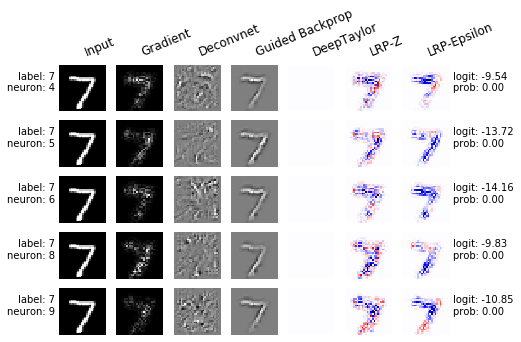

--------------------------------------------------------------------------------
Image nr. 1: 


<Figure size 432x288 with 0 Axes>

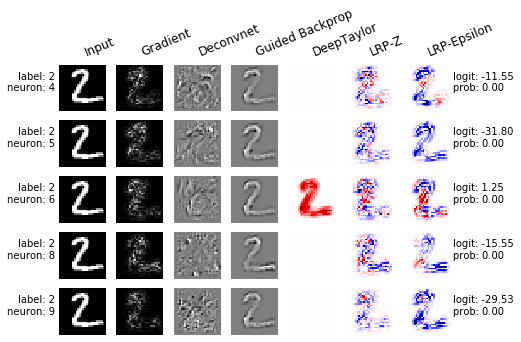

--------------------------------------------------------------------------------
Image nr. 2: 


<Figure size 432x288 with 0 Axes>

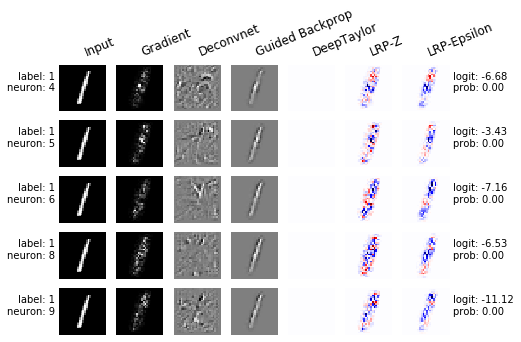

--------------------------------------------------------------------------------
Image nr. 3: 


<Figure size 432x288 with 0 Axes>

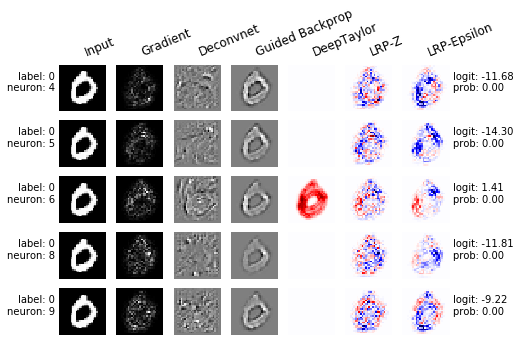

--------------------------------------------------------------------------------
Image nr. 4: 


<Figure size 432x288 with 0 Axes>

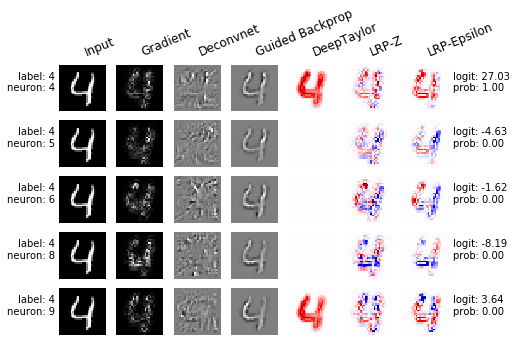

--------------------------------------------------------------------------------
Image nr. 5: 


<Figure size 432x288 with 0 Axes>

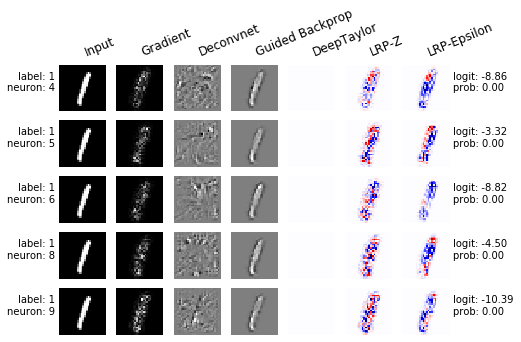

--------------------------------------------------------------------------------
Image nr. 6: 


<Figure size 432x288 with 0 Axes>

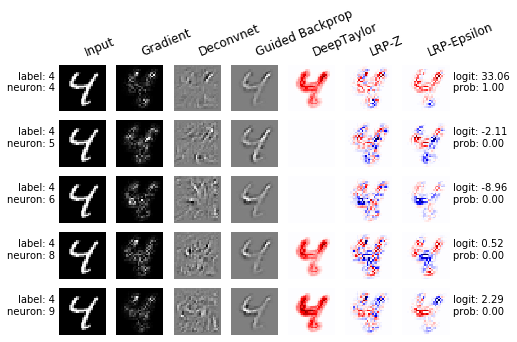

--------------------------------------------------------------------------------
Image nr. 7: 


<Figure size 432x288 with 0 Axes>

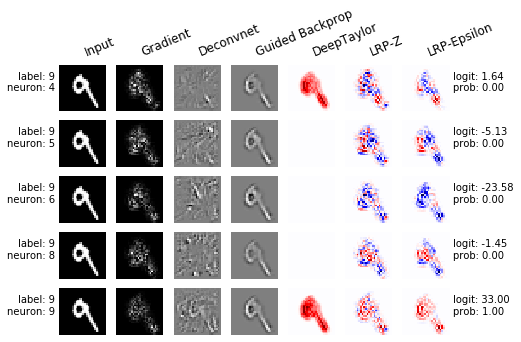

--------------------------------------------------------------------------------
Image nr. 8: 


<Figure size 432x288 with 0 Axes>

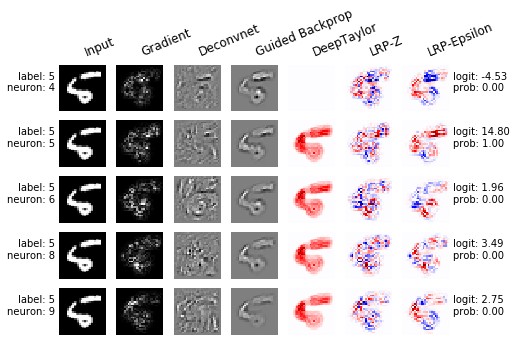

--------------------------------------------------------------------------------
Image nr. 9: 


<Figure size 432x288 with 0 Axes>

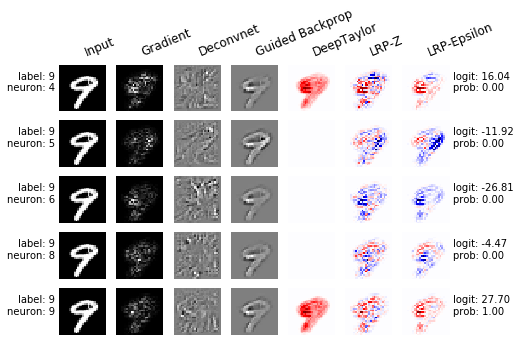

In [7]:
n = 10
test_images = list(zip(data[2][:n], data[3][:n]))

for image_nr, (x, y) in enumerate(test_images):
    # Add batch axis.
    x = x[None, :, :, :]

    analysis = np.zeros([5, len(analyzers), 28, 28, 3])
    text = []

    for ii, output_neuron in enumerate([4, 5, 6, 8, 9]): #range(num_classes):
        # Predict final activations, probabilites, and label.
        presm = model_wo_softmax.predict_on_batch(x)[0]
        prob = model.predict_on_batch(x)[0]
        y_hat = prob.argmax()

        # Save prediction info:
        text.append(("%s" % label_to_class_name[y],    # ground truth label
                     "%.2f" % presm[output_neuron],    # pre-softmax logits
                     "%.2f" % prob[output_neuron],     # probabilistic softmax output  
                     "%s" % label_to_class_name[output_neuron]
                    ))

        for aidx, analyzer in enumerate(analyzers):
            # Analyze.
            a = analyzer.analyze(x, neuron_selection=output_neuron)

            # Apply common postprocessing, e.g., re-ordering the channels for plotting.
            a = mnistutils.postprocess(a)
            # Apply analysis postprocessing, e.g., creating a heatmap.
            a = methods[aidx][2](a)
            # Store the analysis.
            analysis[ii, aidx] = a[0]

    print("-"*80)
    print("Image nr. {}: ".format(image_nr))
    # Prepare the grid as rectengular list
    grid = [[analysis[i, j] for j in range(analysis.shape[1])]
            for i in range(analysis.shape[0])]
    # Prepare the labels
    label, presm, prob, pred = zip(*text)
    row_labels_left = [('label: {}'.format(label[i]), 'neuron: {}'.format(pred[i])) for i in range(len(label))]
    row_labels_right = [('logit: {}'.format(presm[i]), 'prob: {}'.format(prob[i])) for i in range(len(label))]
    col_labels = [''.join(method[3]) for method in methods]

    # Plot the analysis.
    file_name = os.environ.get("PLOTFILENAME", None)
    if file_name is not None:
        file_name = ".".join(file_name.split(".")[:-1])+("_%i" % output_neuron)+file_name.split(".")[-1]
    eutils.plot_image_grid(grid, row_labels_left, row_labels_right, col_labels, file_name=file_name)

--------------------------------------------------------------------------------
Image nr. 0: 


<Figure size 432x288 with 0 Axes>

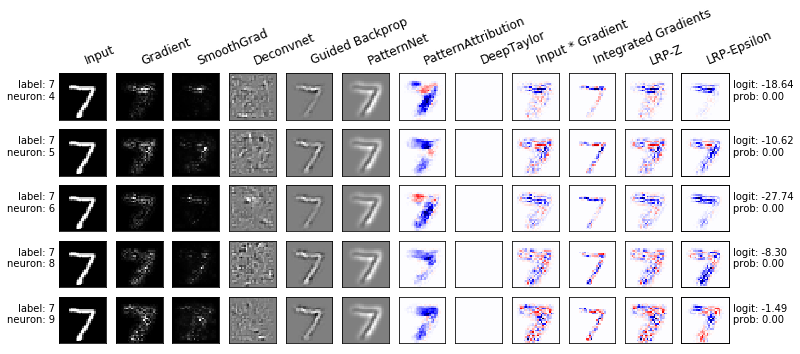

--------------------------------------------------------------------------------
Image nr. 1: 


<Figure size 432x288 with 0 Axes>

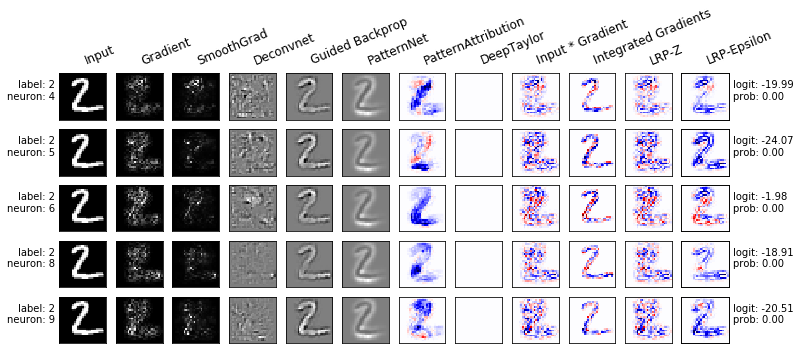

--------------------------------------------------------------------------------
Image nr. 2: 


<Figure size 432x288 with 0 Axes>

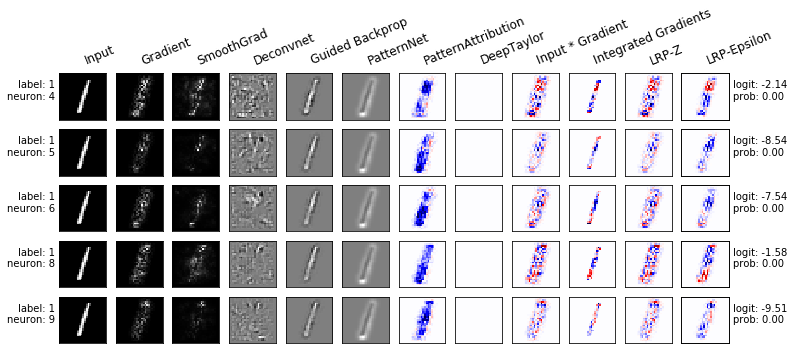

--------------------------------------------------------------------------------
Image nr. 3: 


<Figure size 432x288 with 0 Axes>

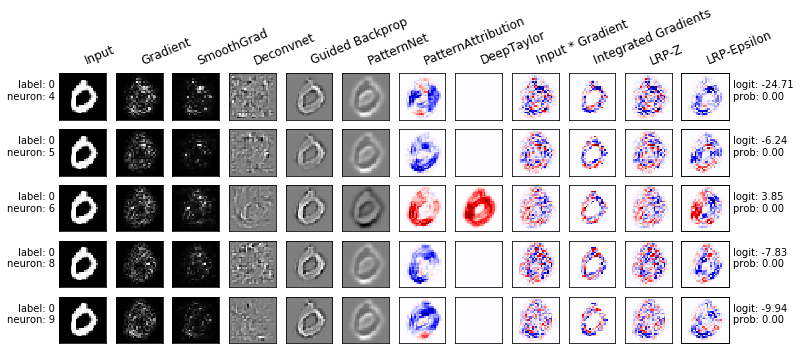

--------------------------------------------------------------------------------
Image nr. 4: 


<Figure size 432x288 with 0 Axes>

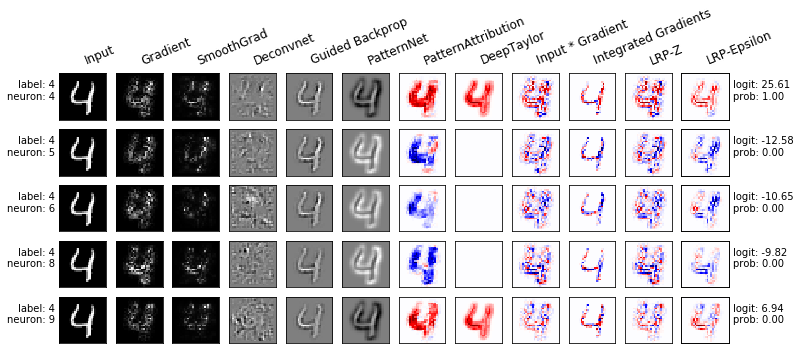

--------------------------------------------------------------------------------
Image nr. 5: 


<Figure size 432x288 with 0 Axes>

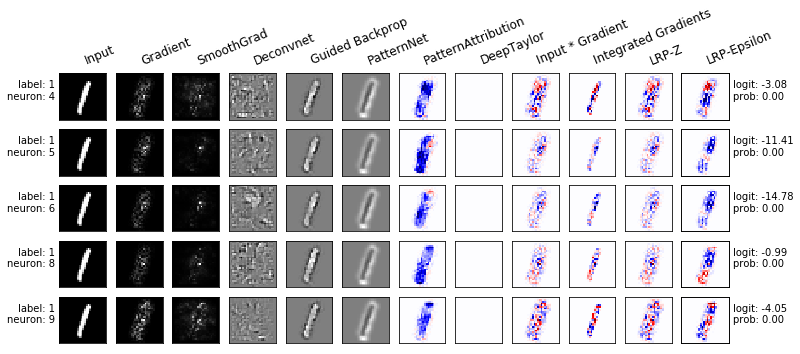

--------------------------------------------------------------------------------
Image nr. 6: 


<Figure size 432x288 with 0 Axes>

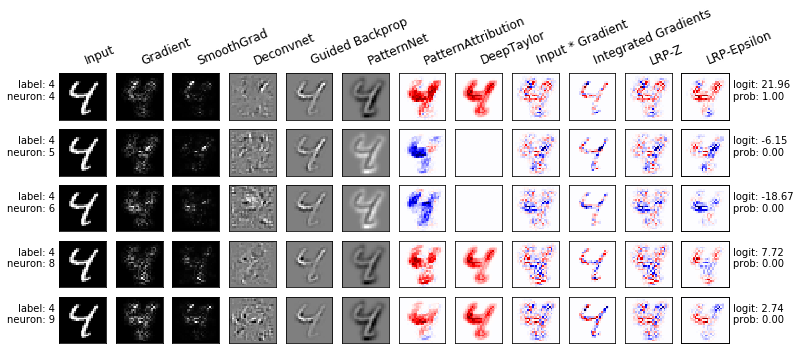

--------------------------------------------------------------------------------
Image nr. 7: 


<Figure size 432x288 with 0 Axes>

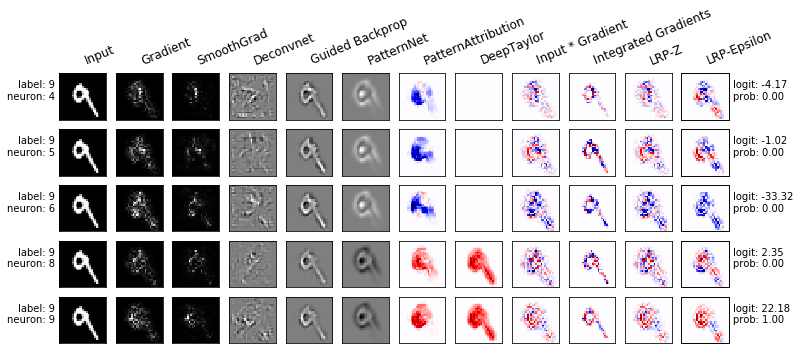

--------------------------------------------------------------------------------
Image nr. 8: 


<Figure size 432x288 with 0 Axes>

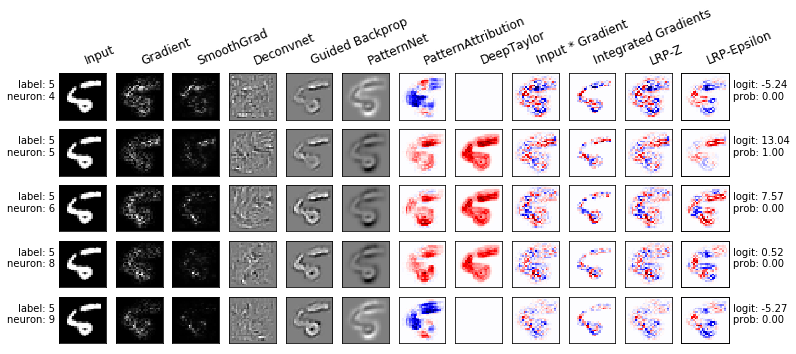

--------------------------------------------------------------------------------
Image nr. 9: 


<Figure size 432x288 with 0 Axes>

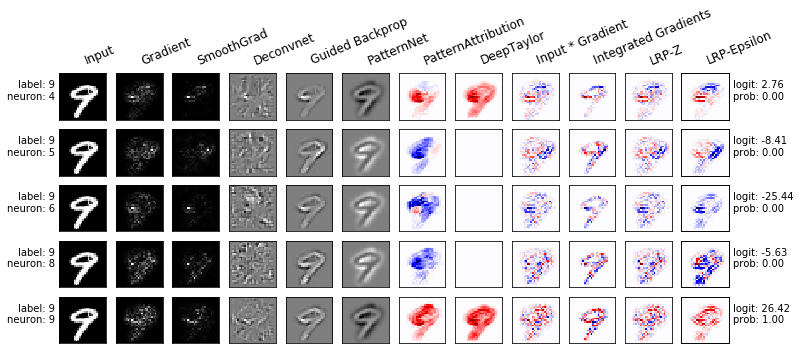

In [7]:
n = 10
test_images = list(zip(data[2][:n], data[3][:n]))

for image_nr, (x, y) in enumerate(test_images):
    # Add batch axis.
    x = x[None, :, :, :]

    analysis = np.zeros([5, len(analyzers), 28, 28, 3])
    text = []

    for ii, output_neuron in enumerate([4, 5, 6, 8, 9]): #range(num_classes):
        # Predict final activations, probabilites, and label.
        presm = model_wo_softmax.predict_on_batch(x)[0]
        prob = model.predict_on_batch(x)[0]
        y_hat = prob.argmax()

        # Save prediction info:
        text.append(("%s" % label_to_class_name[y],    # ground truth label
                     "%.2f" % presm[output_neuron],    # pre-softmax logits
                     "%.2f" % prob[output_neuron],     # probabilistic softmax output  
                     "%s" % label_to_class_name[output_neuron]
                    ))

        for aidx, analyzer in enumerate(analyzers):
            # Analyze.
            a = analyzer.analyze(x, neuron_selection=output_neuron)

            # Apply common postprocessing, e.g., re-ordering the channels for plotting.
            a = mnistutils.postprocess(a)
            # Apply analysis postprocessing, e.g., creating a heatmap.
            a = methods[aidx][2](a)
            # Store the analysis.
            analysis[ii, aidx] = a[0]

    print("-"*80)
    print("Image nr. {}: ".format(image_nr))
    # Prepare the grid as rectengular list
    grid = [[analysis[i, j] for j in range(analysis.shape[1])]
            for i in range(analysis.shape[0])]
    # Prepare the labels
    label, presm, prob, pred = zip(*text)
    row_labels_left = [('label: {}'.format(label[i]), 'neuron: {}'.format(pred[i])) for i in range(len(label))]
    row_labels_right = [('logit: {}'.format(presm[i]), 'prob: {}'.format(prob[i])) for i in range(len(label))]
    col_labels = [''.join(method[3]) for method in methods]

    # Plot the analysis.
    file_name = os.environ.get("PLOTFILENAME", None)
    if file_name is not None:
        file_name = ".".join(file_name.split(".")[:-1])+("_%i" % output_neuron)+file_name.split(".")[-1]
    eutils.plot_image_grid(grid, row_labels_left, row_labels_right, col_labels, file_name=file_name)

Each column shows the visualized results for different analyzers and each row shows the analyses w.r.t. to one input sample. To the left of each row, the ground truth label `label` and the predicted label `pred` are show. To the right, the model's probabilistic (softmax) output is shown as `prob` and the logit output just before the terminating softmax layer as `logit`. Note that all analyses have been performed based on the logit output (layer).

If you are curious about how *iNNvestigate* performs on ImageNet model, have a look here: [Comparing methods on ImageNet](imagenet_method_comparison.ipynb) and [Comparing networks on ImagenNet](imagenet_network_comparison.ipynb)